In [7]:
 import pandas as pd
from Bio import Entrez, SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
def download_genome_sequence(accession):
    """Download genome sequence from GenBank"""
    handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
    return SeqIO.read(handle, "genbank")

# Download the three genome sequences
accessions = ["CP070375.1", "CP070376.1", "CP070377.1","U00096","CP002175.1"]
genome_records = {}

for acc in accessions:
    genome_records[acc] = download_genome_sequence(acc)
    print(f"Downloaded sequence: {acc}")

Downloaded sequence: CP070375.1
Downloaded sequence: CP070376.1
Downloaded sequence: CP070377.1
Downloaded sequence: U00096
Downloaded sequence: CP002175.1
Downloaded sequence: NC_002607 NZ_AE004970-NZ_AE005139


In [173]:
import pandas as pd
from Bio import Entrez, SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import defaultdict

def download_genome_sequence(accession):
    """Download genome sequence from GenBank."""
    print(f"Downloading genome for accession: {accession}")
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
        return SeqIO.read(handle, "genbank")
    except Exception as e:
        print(f"Error downloading accession {accession}: {e}")
        return None

def read_genome_from_file(file_path, file_format="genbank"):
    """Read genome sequence from a local file."""
    print(f"Reading genome from file: {file_path}")
    try:
        return SeqIO.read(file_path, file_format)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

class GenomeAnalyzer:
    def __init__(self):
        self.acidic_aa = ['D', 'E']  # Aspartate and Glutamate
        self.hydrophobic_aa = ['A', 'I', 'L', 'M', 'F', 'W', 'V']  # Hydrophobic residues
        self.osmotic_balance_patterns = {
            'betaine': ['betaine', 'glycine betaine', 'gbt', 'bet'],
            'potassium': ['trk', 'kdp', 'kef', 'ktr'],
            'antiporter': ['nha', 'anti', 'porter', 'nhaC', 'nhaD']
        }

    def calculate_gc_content(self, genome):
        """Calculate GC content of the genome."""
        sequence = str(genome.seq)
        return (sequence.count('G') + sequence.count('C')) / len(sequence) * 100

    def analyze_protein_features(self, genome):
        """Analyze acidic and hydrophobic residues in proteins."""
        acidic_residues = 0
        hydrophobic_residues = 0
        total_length = 0

        for feature in genome.features:
            if feature.type == "CDS" and 'translation' in feature.qualifiers:
                protein_seq = feature.qualifiers['translation'][0]
                protein_analysis = ProteinAnalysis(protein_seq)

                # Count residues
                acidic_residues += sum(protein_analysis.count_amino_acids().get(aa, 0) for aa in self.acidic_aa)
                hydrophobic_residues += sum(protein_analysis.count_amino_acids().get(aa, 0) for aa in self.hydrophobic_aa)
                total_length += len(protein_seq)

        if total_length > 0:
            return {
                'average_acidic_content': (acidic_residues / total_length) * 100,
                'acidic_residues': acidic_residues,
                'average_hydrophobic_content': (hydrophobic_residues / total_length) * 100,
                'hydrophobic_residues': hydrophobic_residues
            }
        else:
            return {
                'average_acidic_content': 0,
                'acidic_residues': 0,
                'average_hydrophobic_content': 0,
                'hydrophobic_residues': 0
            }

    def analyze_osmotic_genes(self, genome):
        """Identify osmotic regulation genes."""
        osmotic_genes = defaultdict(list)

        for feature in genome.features:
            if feature.type == "CDS":
                product = feature.qualifiers.get('product', [''])[0].lower()
                for mechanism, patterns in self.osmotic_balance_patterns.items():
                    if any(pattern in product for pattern in patterns):
                        osmotic_genes[mechanism].append(product)

        return {k: len(v) for k, v in osmotic_genes.items()}

    def analyze_genome(self, genome):
        """Perform all required analyses for a genome."""
        gc_content = self.calculate_gc_content(genome)
        protein_features = self.analyze_protein_features(genome)
        osmotic_genes = self.analyze_osmotic_genes(genome)

        return {
            'gc_content': gc_content,
            'average_acidic_content': protein_features['average_acidic_content'],
            'acidic_residues': protein_features['acidic_residues'],
            'average_hydrophobic_content': protein_features['average_hydrophobic_content'],
            'hydrophobic_residues': protein_features['hydrophobic_residues'],
            'osmotic_genes': osmotic_genes
        }

def main():
    Entrez.email = "your_email@example.com"  # Replace with your NCBI Entrez email
    
    # Use a dictionary to map names to accession numbers
    accessions = {
        "GSL-19 Chromosome": "CP070377.1",
        "GSL-19 Plasmid 1": "CP070375.1",
        "GSL-19 Plasmid 2": "CP070376.1",
        "E. coli Chromosome": "U00096",
        "Moderate Halophile Chromosome": "CP002175.1",
        "NMX12-1": "CP159204.1",
        "NMX12-1 Plasmid 1": "CP159203",
        "NMX12-1 Plasmid 2": "CP159205",
        "NMX12-1 Plasmid 3": "CP159206",
        "NMX12-1 Plasmid 4": "CP159207",
        "NMX12-1 Plasmid 5": "CP159208",
        "NRC-1":"AE004437.1",
        "NRC-1 Plasmid 1": "AE004438.1",
        "NRC-1 Plasmid 2": "AF016485"

    }

    analyzer = GenomeAnalyzer()
    genome_records = {}

    # Download genomes and map them to their names
    for name, acc in accessions.items():
        print(f"\nFetching genome: {name} ({acc})...")
        genome = download_genome_sequence(acc)
        if genome:
            genome_records[name] = genome

    # Analyze each genome and print results
    for name, genome in genome_records.items():
        print(f"\nAnalyzing genome: {name}")
        results = analyzer.analyze_genome(genome)

        # Output the results
        print(f"GC Content: {results['gc_content']:.2f}%")
        print(f"Average Acidic Content: {results['average_acidic_content']:.2f}%")
        print(f"Acidic Residues: {results['acidic_residues']}")
        print(f"Average Hydrophobic Content: {results['average_hydrophobic_content']:.2f}%")
        print(f"Hydrophobic Residues: {results['hydrophobic_residues']}")
        print("Osmotic Regulation Genes:")
        for mechanism, count in results['osmotic_genes'].items():
            print(f"  {mechanism}: {count}")

if __name__ == "__main__":
    main()



Fetching genome: GSL-19 Chromosome (CP070377.1)...

Fetching genome: GSL-19 Plasmid 1 (CP070375.1)...

Fetching genome: GSL-19 Plasmid 2 (CP070376.1)...

Fetching genome: E. coli Chromosome (U00096)...

Fetching genome: Moderate Halophile Chromosome (CP002175.1)...

Fetching genome: NMX12-1 (CP159204.1)...

Fetching genome: NMX12-1 Plasmid 1 (CP159203)...

Fetching genome: NMX12-1 Plasmid 2 (CP159205)...

Fetching genome: NMX12-1 Plasmid 3 (CP159206)...

Fetching genome: NMX12-1 Plasmid 4 (CP159207)...

Fetching genome: NMX12-1 Plasmid 5 (CP159208)...

Fetching genome: NRC-1 (AE004437.1)...

Fetching genome: NRC-1 Plasmid 1 (AE004438.1)...

Fetching genome: NRC-1 Plasmid 2 (AF016485)...

Analyzing genome: GSL-19 Chromosome
GC Content: 67.99%
Average Acidic Content: 15.75%
Acidic Residues: 94130
Average Hydrophobic Content: 40.89%
Hydrophobic Residues: 244323
Osmotic Regulation Genes:
  antiporter: 134
  potassium: 6
  betaine: 25

Analyzing genome: GSL-19 Plasmid 1
GC Content: 59.07%


Fetching genome: GSL-19 Chromosome (CP070377.1)...
Analyzing genome: GSL-19 Chromosome
Fetching genome: GSL-19 Plasmid 1 (CP070375.1)...
Analyzing genome: GSL-19 Plasmid 1
Fetching genome: GSL-19 Plasmid 2 (CP070376.1)...
Analyzing genome: GSL-19 Plasmid 2
Fetching genome: NRC-1 Chromosome (AE004437.1)...
Analyzing genome: NRC-1 Chromosome
Fetching genome: NRC-1 Plasmid 1 (AE004438.1)...
Analyzing genome: NRC-1 Plasmid 1
Fetching genome: NRC-1 Plasmid 2 (AE004439.1)...
Analyzing genome: NRC-1 Plasmid 2
Fetching genome: NMX12-1 Chromosome (CP159204.1)...
Analyzing genome: NMX12-1 Chromosome
Fetching genome: NMX12-1 Plasmid 1 (CP159203)...
Analyzing genome: NMX12-1 Plasmid 1
Fetching genome: NMX12-1 Plasmid 2 (CP159205)...
Analyzing genome: NMX12-1 Plasmid 2
Fetching genome: NMX12-1 Plasmid 3 (CP159206)...
Analyzing genome: NMX12-1 Plasmid 3
Fetching genome: NMX12-1 Plasmid 4 (CP159207)...
Analyzing genome: NMX12-1 Plasmid 4
Fetching genome: NMX12-1 Plasmid 5 (CP159208)...
Analyzing geno

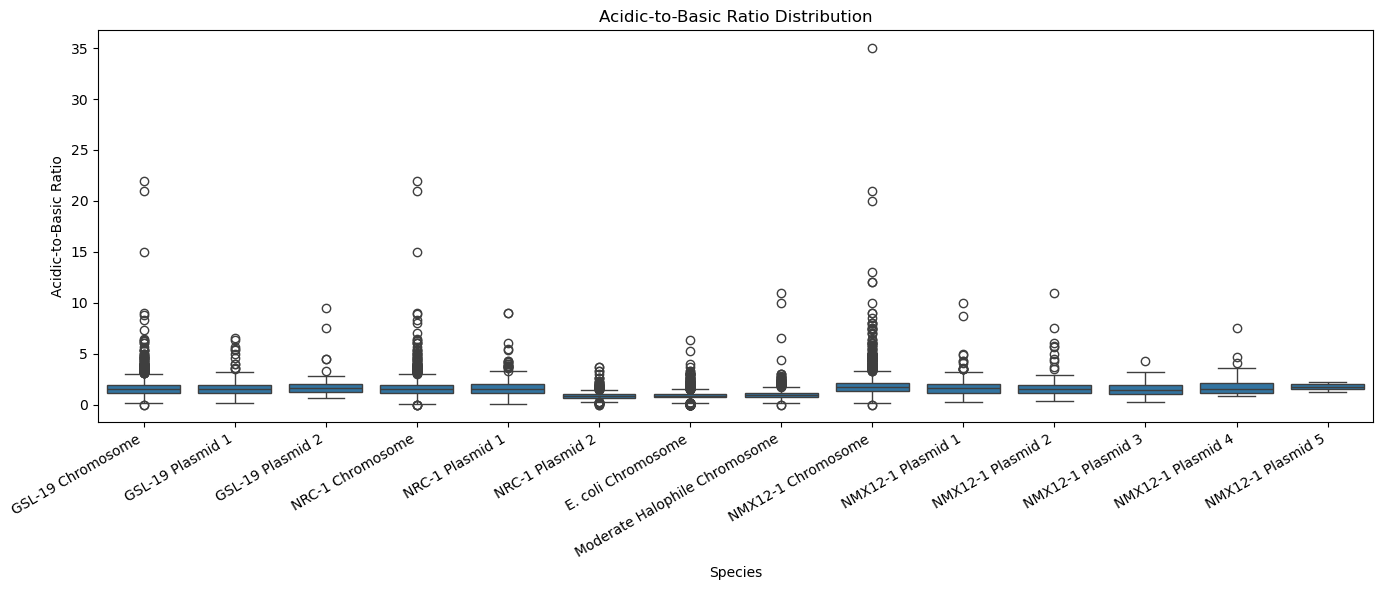

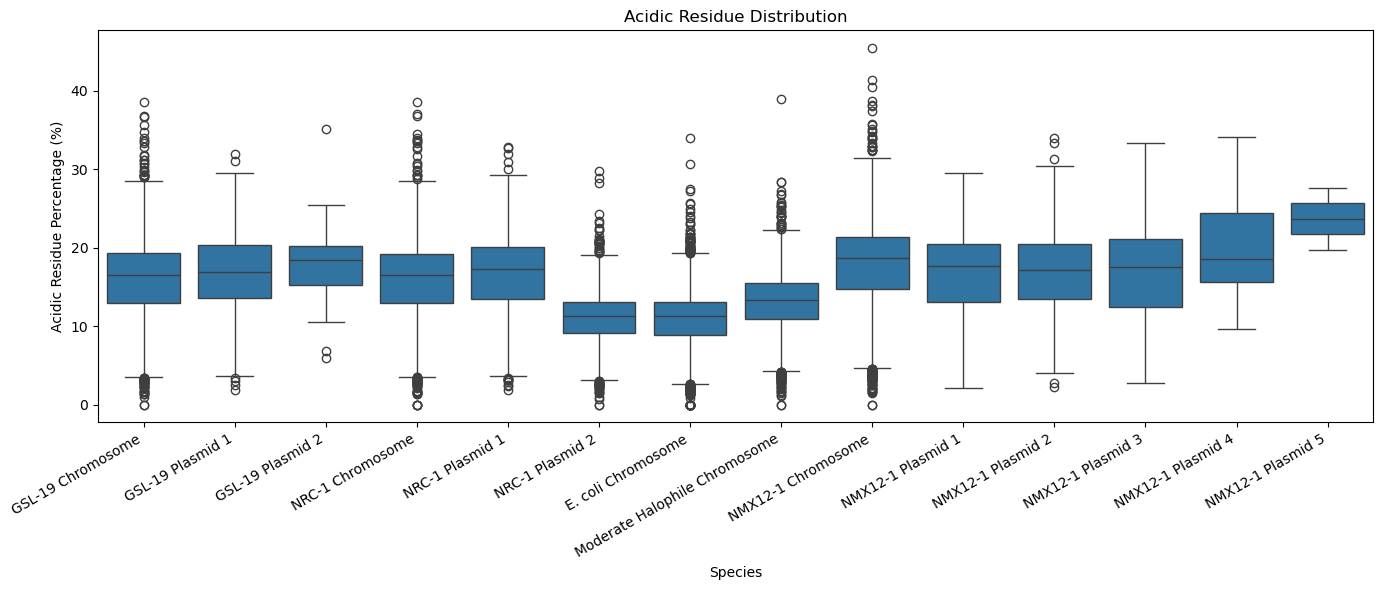

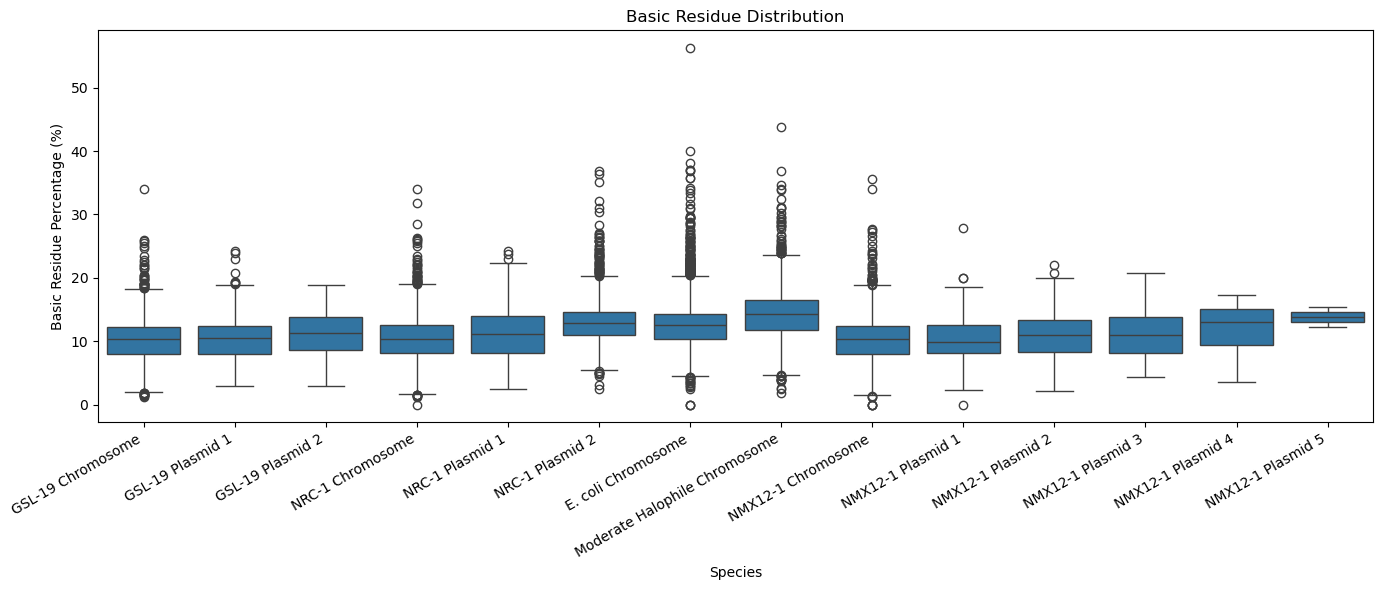

In [161]:
import pandas as pd
from Bio import SeqIO, Entrez
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import seaborn as sns


class ComparativeGenomics:
    def __init__(self):
        # Define reference genomes with accession numbers
        self.reference_genomes = {
            "GSL-19 Chromosome": "CP070377.1",
            "GSL-19 Plasmid 1": "CP070375.1",
            "GSL-19 Plasmid 2": "CP070376.1",
            "NRC-1 Chromosome": "AE004437.1",
            "NRC-1 Plasmid 1": "AE004438.1",
            "NRC-1 Plasmid 2": "AE004439.1",
            "NMX12-1 Chromosome": "CP159204.1",
            "NMX12-1 Plasmid 1": "CP159203",
            "NMX12-1 Plasmid 2": "CP159205",
            "NMX12-1 Plasmid 3": "CP159206",
            "NMX12-1 Plasmid 4": "CP159207",
            "NMX12-1 Plasmid 5": "CP159208",
            "Moderate Halophile Chromosome": "CP002175.1",
            "E. coli Chromosome": "U00096",
        }

        # Define amino acid classifications
        self.acidic_aa = ['D', 'E']  # Aspartate and Glutamate
        self.basic_aa = ['K', 'R', 'H']  # Lysine, Arginine, and Histidine

    def fetch_genome(self, accession):
        """Fetch genome from NCBI using accession number."""
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()
            return record
        except Exception as e:
            print(f"Error fetching genome {accession}: {e}")
            return None

    def analyze_protein_adaptations(self, genome_record):
        """Analyze proteins for acidic and basic residue content."""
        protein_features = []
        for feature in genome_record.features:
            if feature.type == "CDS" and "translation" in feature.qualifiers:
                protein_seq = feature.qualifiers["translation"][0]
                try:
                    protein_analysis = ProteinAnalysis(protein_seq)
                    acidic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.acidic_aa)
                    basic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.basic_aa)

                    protein_info = {
                        'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                        'acidic_percentage': (acidic_content / len(protein_seq)) * 100,
                        'basic_percentage': (basic_content / len(protein_seq)) * 100,
                        'acidic_to_basic_ratio': acidic_content / (basic_content if basic_content > 0 else 1),
                    }
                    protein_features.append(protein_info)
                except Exception as e:
                    print(f"Error analyzing protein {feature.qualifiers.get('locus_tag', ['Unknown'])[0]}: {e}")
        return pd.DataFrame(protein_features)

    def plot_combined_distribution(self, data, value_col, title, ylabel, species_order):
        """Plot combined distributions for plasmids and chromosomes."""
        data['Species'] = pd.Categorical(data['Species'], categories=species_order, ordered=True)
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=data, x='Species', y=value_col)
        plt.title(title)
        plt.xlabel('Species')
        plt.ylabel(ylabel)
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()


def main():
    Entrez.email = "your_email@example.com"  # Replace with your email

    analyzer = ComparativeGenomics()

    protein_features_dfs = []  # Store protein features for each species
    species_order = [
        "GSL-19 Chromosome", "GSL-19 Plasmid 1", "GSL-19 Plasmid 2",
        "NRC-1 Chromosome", "NRC-1 Plasmid 1", "NRC-1 Plasmid 2",
        "E. coli Chromosome", "Moderate Halophile Chromosome",
        "NMX12-1 Chromosome", "NMX12-1 Plasmid 1", "NMX12-1 Plasmid 2",
        "NMX12-1 Plasmid 3", "NMX12-1 Plasmid 4", "NMX12-1 Plasmid 5"
    ]

    # Fetch and analyze genomes
    for name, accession in analyzer.reference_genomes.items():
        print(f"Fetching genome: {name} ({accession})...")
        genome = analyzer.fetch_genome(accession)
        if genome:
            print(f"Analyzing genome: {name}")
            protein_features = analyzer.analyze_protein_adaptations(genome)
            protein_features['Species'] = name
            protein_features_dfs.append(protein_features)

    # Combine all protein features into a single DataFrame
    combined_df = pd.concat(protein_features_dfs)

    # Plot distributions
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_to_basic_ratio', 'Acidic-to-Basic Ratio Distribution', 'Acidic-to-Basic Ratio', species_order
    )
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_percentage', 'Acidic Residue Distribution', 'Acidic Residue Percentage (%)', species_order
    )
    analyzer.plot_combined_distribution(
        combined_df, 'basic_percentage', 'Basic Residue Distribution', 'Basic Residue Percentage (%)', species_order
    )


if __name__ == "__main__":
    main()



Fetching genome: GSL-19 Chromosome (CP070377.1)...

Fetching genome: GSL-19 Plasmid 1 (CP070375.1)...

Fetching genome: GSL-19 Plasmid 2 (CP070376.1)...

Fetching genome: E. coli Chromosome (U00096)...

Fetching genome: Moderate Halophile Chromosome (CP002175.1)...

Reading genome from local file: project bmi/sequence (2).gb
Reading genome from file: project bmi/sequence (2).gb

Reading genome from local file: project bmi/NRC-1 complete genome.gb
Reading genome from file: project bmi/NRC-1 complete genome.gb

Reading genome from local file: project bmi/NRC-1 Plasmid 1.gb
Reading genome from file: project bmi/NRC-1 Plasmid 1.gb

Reading genome from local file: project bmi/NRC-1 Plasmid 2.gb
Reading genome from file: project bmi/NRC-1 Plasmid 2.gb

Analyzing genome: GSL-19 Chromosome

Analyzing genome: GSL-19 Plasmid 1

Analyzing genome: GSL-19 Plasmid 2

Analyzing genome: E. coli Chromosome

Analyzing genome: Moderate Halophile Chromosome

Analyzing genome: e_coli (file upload test)

A

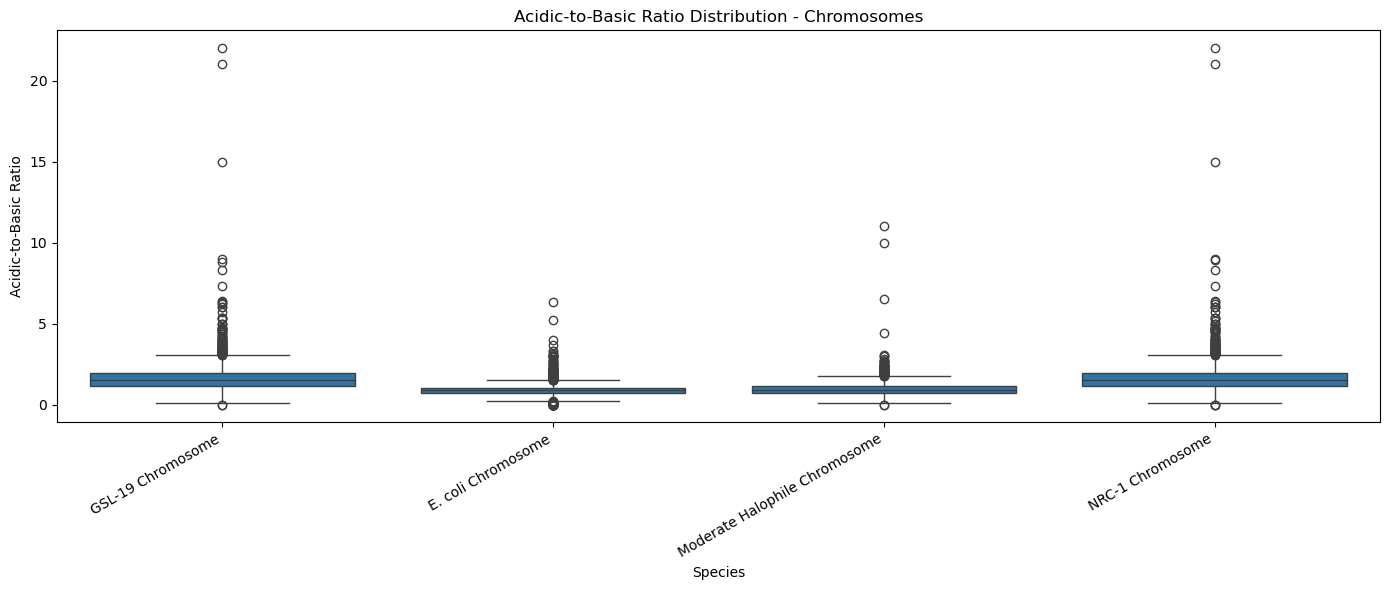

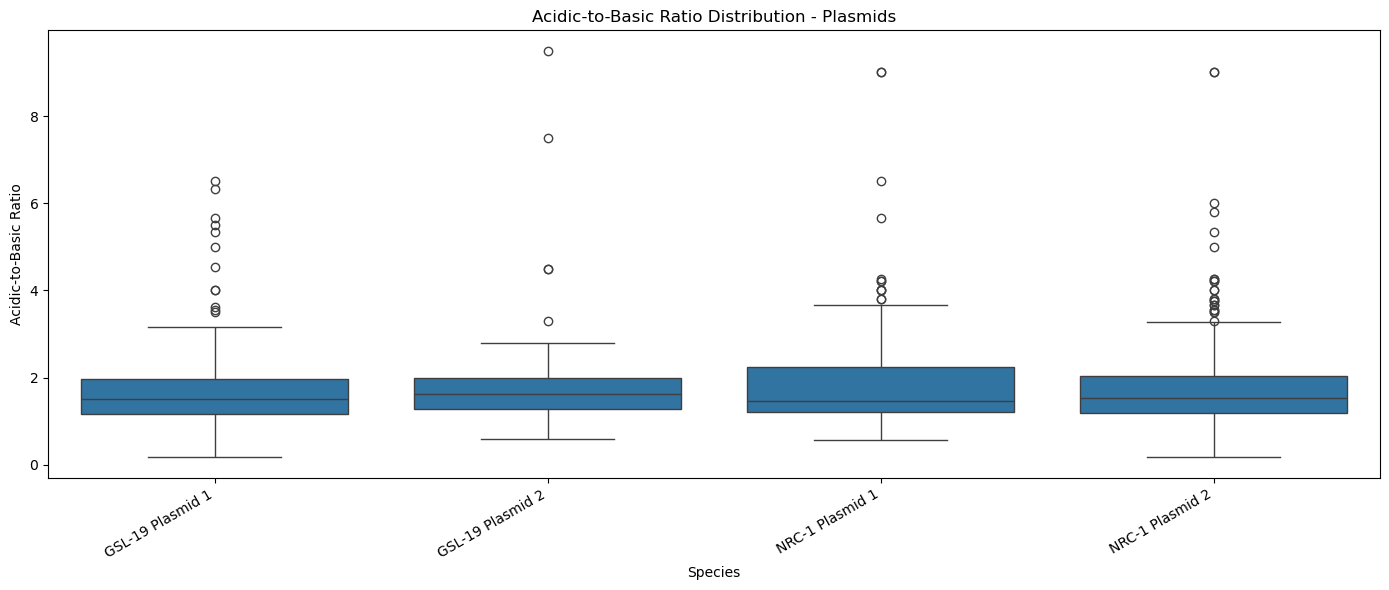

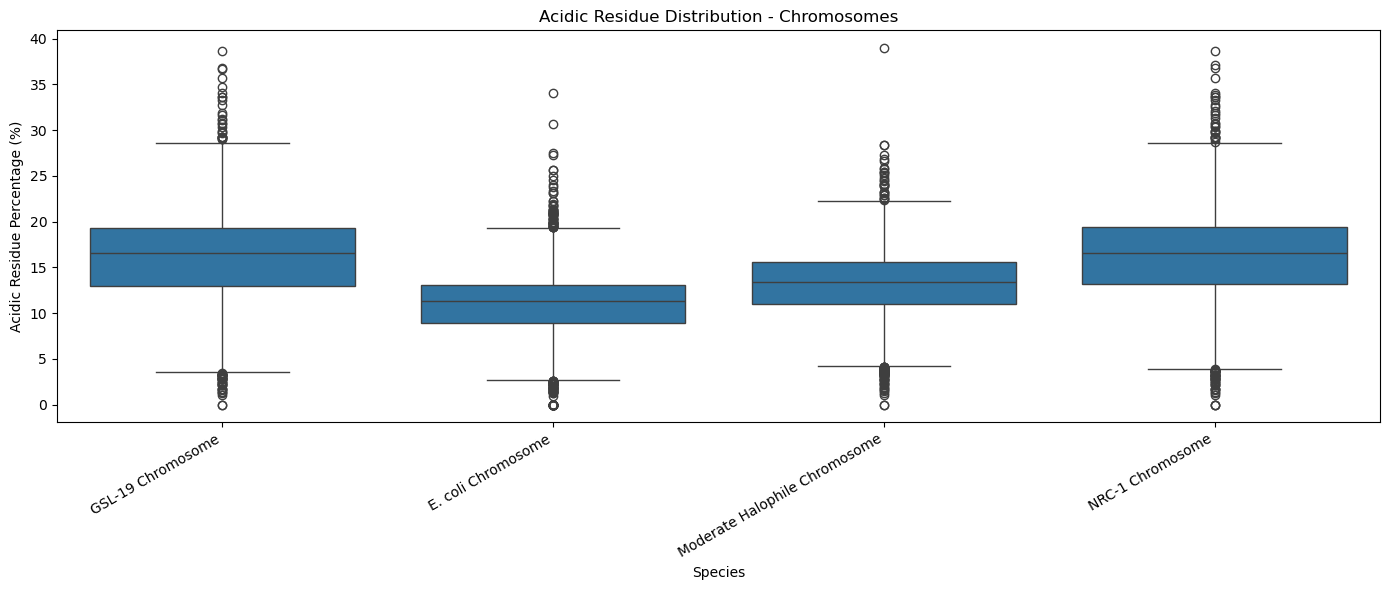

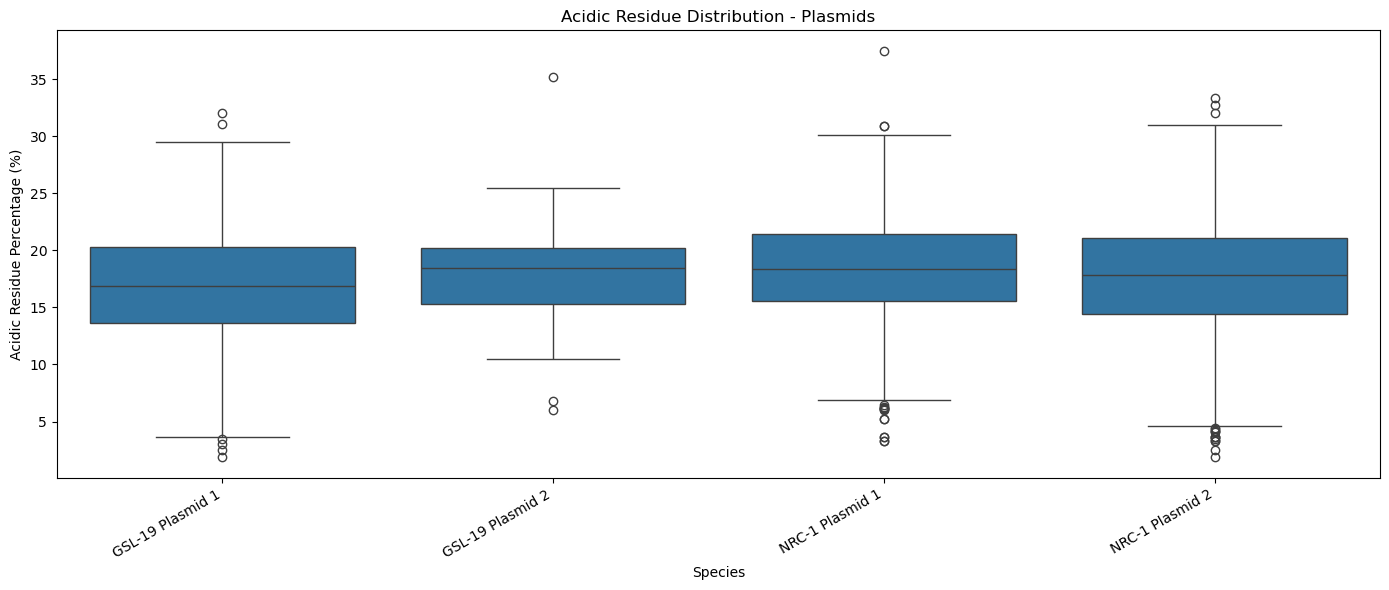

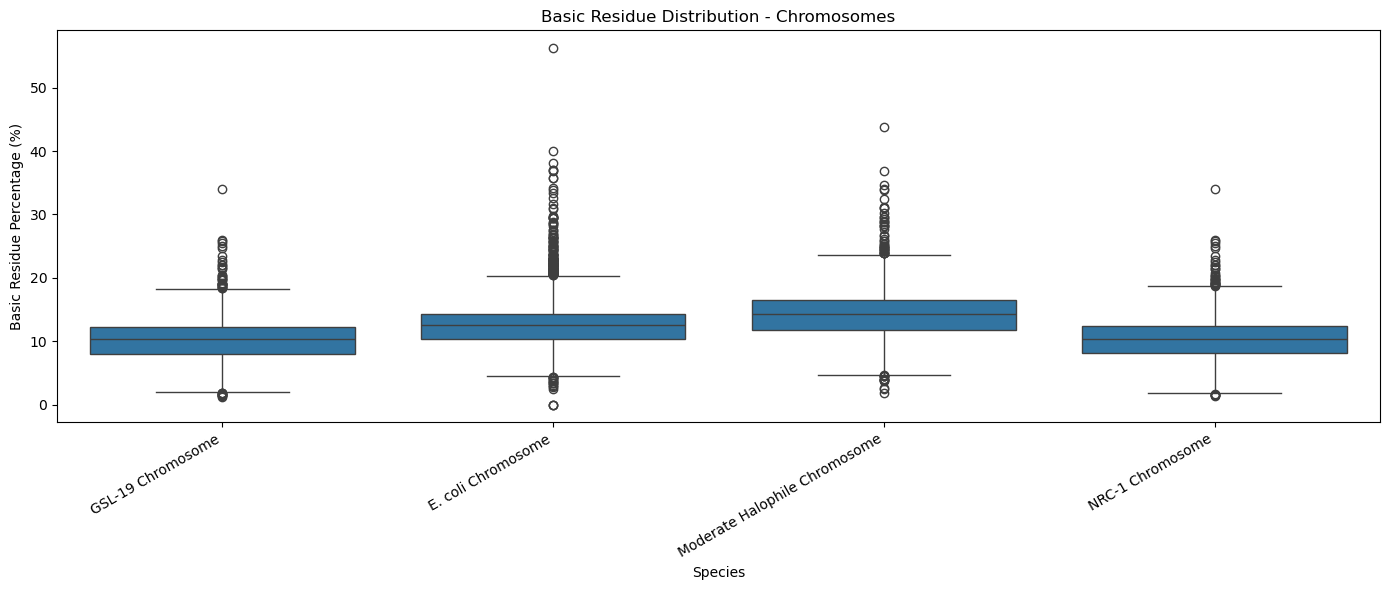

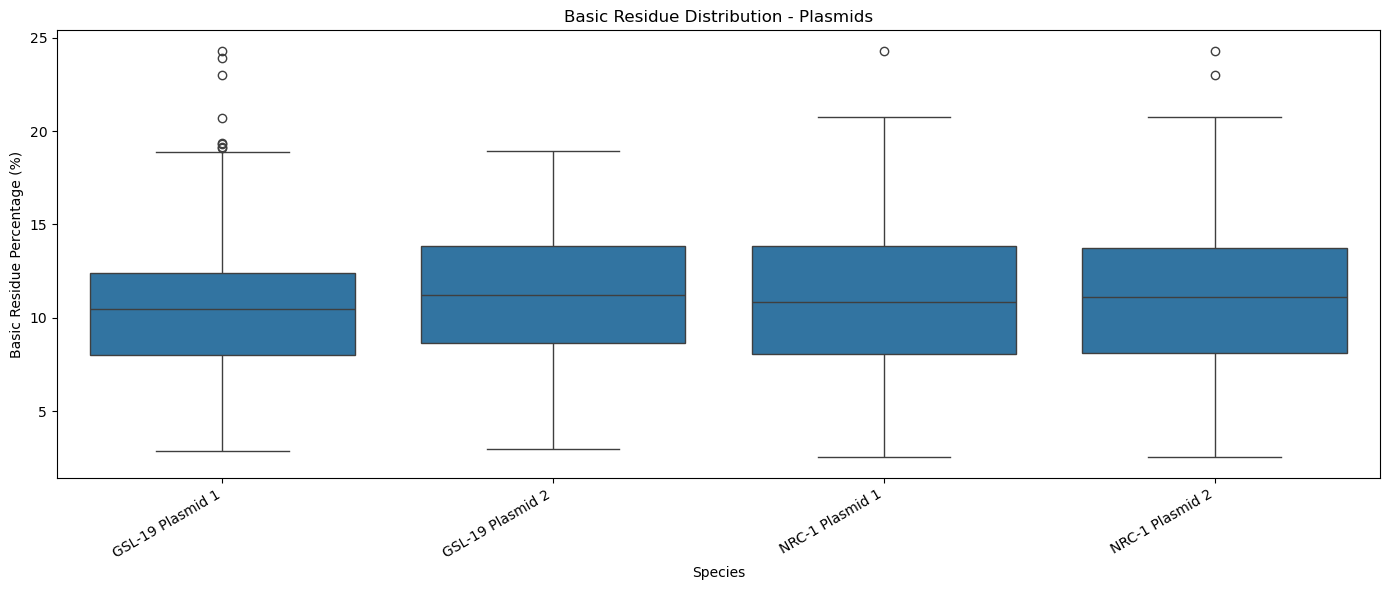

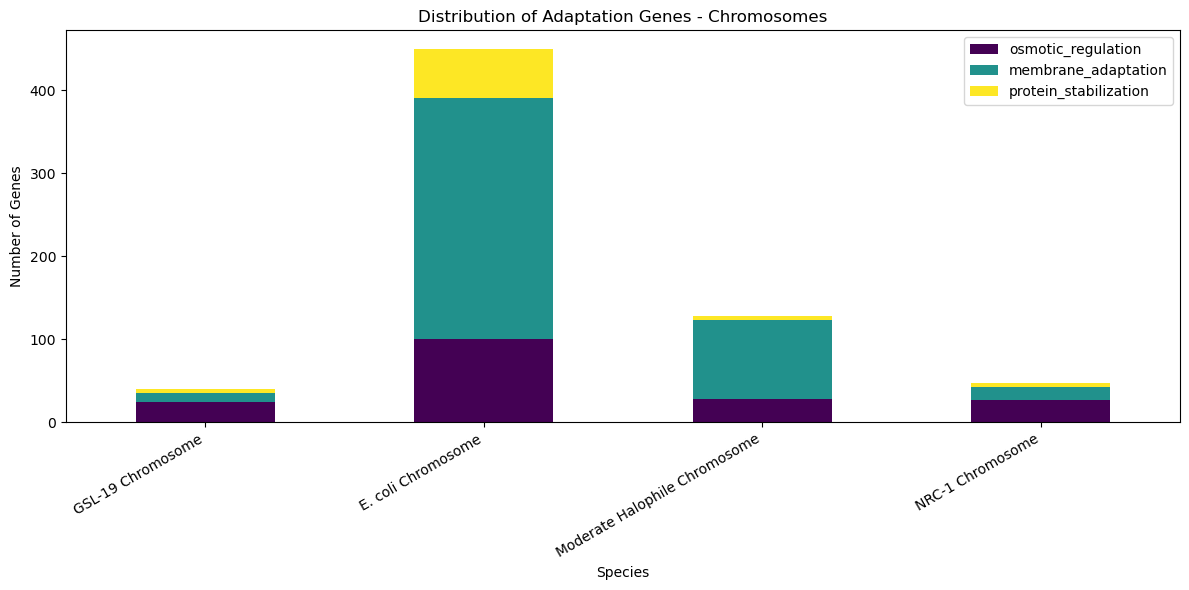

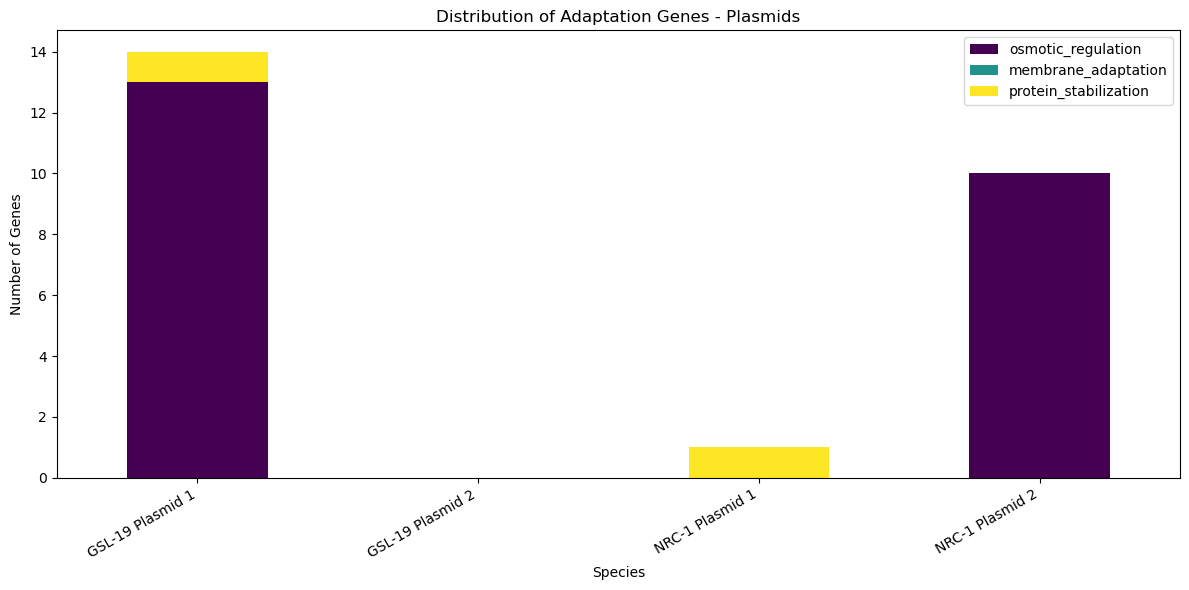

In [21]:
import pandas as pd
from Bio import SeqIO, Entrez
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns


class ComparativeGenomics:
    def __init__(self):
        # Define reference genomes
        self.reference_genomes = {
            "GSL-19 Chromosome": "CP070377.1",
            "GSL-19 Plasmid 1": "CP070375.1",
            "GSL-19 Plasmid 2": "CP070376.1",
            "E. coli Chromosome": "U00096",
            "Moderate Halophile Chromosome": "CP002175.1",
        }
        self.local_files = {
            'e_coli (file upload test)': "project bmi/sequence (2).gb",
            "NRC-1 Chromosome": "project bmi/NRC-1 complete genome.gb",
            "NRC-1 Plasmid 1": "project bmi/NRC-1 Plasmid 1.gb",
            "NRC-1 Plasmid 2": "project bmi/NRC-1 Plasmid 2.gb"
        }

        # Define amino acid classifications
        self.acidic_aa = ['D', 'E']  # Aspartate (D) and Glutamate (E) are acidic.
        self.basic_aa = ['K', 'R', 'H']  # Lysine (K), Arginine (R), and Histidine (H) are basic.

        # Define adaptation patterns
        self.adaptation_patterns = {
            'osmotic_regulation': ['betaine', 'potassium', 'antiporter', 'symport'],
            'protein_stabilization': ['chaperone', 'folding', 'stability'],
            'membrane_adaptation': ['lipid', 'wall', 'membrane']
        }

    def read_genome_from_file(self, file_path, file_format="genbank"):
        """Read genome sequence from a local file."""
        print(f"Reading genome from file: {file_path}")
        try:
            return SeqIO.read(file_path, file_format)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return None

    def fetch_genome(self, accession):
        """Fetch genome from NCBI."""
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()
            return record
        except Exception as e:
            print(f"Error fetching {accession}: {str(e)}")
            return None

    def analyze_protein_adaptations(self, genome_record):
        """Analyze proteins for characteristics associated with halophilic adaptations."""
        protein_features = []

        for feature in genome_record.features:
            if feature.type == "CDS" and 'translation' in feature.qualifiers:
                protein_seq = feature.qualifiers['translation'][0]
                try:
                    protein_analysis = ProteinAnalysis(protein_seq)
                    acidic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.acidic_aa)
                    basic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.basic_aa)

                    protein_info = {
                        'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                        'acidic_percentage': (acidic_content / len(protein_seq)) * 100,
                        'basic_percentage': (basic_content / len(protein_seq)) * 100,
                        'acidic_to_basic_ratio': acidic_content / (basic_content if basic_content > 0 else 1)
                    }
                    protein_features.append(protein_info)
                except Exception as e:
                    print(f"Error analyzing protein {feature.qualifiers.get('locus_tag', ['Unknown'])[0]}: {str(e)}")

        return pd.DataFrame(protein_features)

    def analyze_adaptation_genes(self, genome_record):
        """Identify adaptation-related genes."""
        adaptation_genes = defaultdict(int)

        for feature in genome_record.features:
            if feature.type == "CDS":
                product = feature.qualifiers.get('product', [''])[0].lower()
                for category, patterns in self.adaptation_patterns.items():
                    if any(pattern in product for pattern in patterns):
                        adaptation_genes[category] += 1

        return adaptation_genes

    def plot_distribution_by_category(self, data, value_col, title, ylabel):
        """Generic plot function to visualize distributions for plasmids and chromosomes separately."""
        chromosomes = data[data['Species'].str.contains("Chromosome")]
        plasmids = data[data['Species'].str.contains("Plasmid")]

        # Chromosomes
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=chromosomes, x='Species', y=value_col)
        plt.title(f'{title} - Chromosomes')
        plt.xlabel('Species')
        plt.ylabel(ylabel)
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

        # Plasmids
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=plasmids, x='Species', y=value_col)
        plt.title(f'{title} - Plasmids')
        plt.xlabel('Species')
        plt.ylabel(ylabel)
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

    def plot_adaptation_genes_distribution(self, adaptation_genes_list, labels):
        """Plot the distribution of adaptation genes for plasmids and chromosomes separately."""
        adaptation_data = pd.DataFrame(adaptation_genes_list, index=labels).fillna(0)
        chromosomes = adaptation_data.loc[adaptation_data.index.str.contains("Chromosome")]
        plasmids = adaptation_data.loc[adaptation_data.index.str.contains("Plasmid")]

        # Chromosomes
        chromosomes.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
        plt.title('Distribution of Adaptation Genes - Chromosomes')
        plt.ylabel('Number of Genes')
        plt.xlabel('Species')
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

        # Plasmids
        plasmids.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
        plt.title('Distribution of Adaptation Genes - Plasmids')
        plt.ylabel('Number of Genes')
        plt.xlabel('Species')
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()


def main():
    analyzer = ComparativeGenomics()
    Entrez.email = "your_email@example.com"  # Replace with your email

    protein_features_dfs = []  # Store protein features for each species
    adaptation_genes_list = []  # Store adaptation genes count for each species
    gc_content_results = {}  # Store GC content results for each species
    labels = []  # Store species labels

    genome_records = {}

    # Fetch and analyze remote genomes
    for name, accession in analyzer.reference_genomes.items():
        print(f"\nFetching genome: {name} ({accession})...")
        genome = analyzer.fetch_genome(accession)
        if genome:
            genome_records[name] = genome

    # Read and analyze local genome files
    for label, file_path in analyzer.local_files.items():
        print(f"\nReading genome from local file: {file_path}")
        genome = analyzer.read_genome_from_file(file_path)
        if genome:
            genome_records[label] = genome

    # Analyze all genomes
    for name, genome in genome_records.items():
        print(f"\nAnalyzing genome: {name}")
        protein_features = analyzer.analyze_protein_adaptations(genome)
        protein_features['Species'] = name
        protein_features_dfs.append(protein_features)

        adaptation_genes = analyzer.analyze_adaptation_genes(genome)
        adaptation_genes_list.append(adaptation_genes)

        labels.append(name)

    # Combine protein feature data
    combined_df = pd.concat(protein_features_dfs)

    # Plot acidic-to-basic ratio
    analyzer.plot_distribution_by_category(
        combined_df, 'acidic_to_basic_ratio', 'Acidic-to-Basic Ratio Distribution', 'Acidic-to-Basic Ratio'
    )

    # Plot acidic residue distribution
    analyzer.plot_distribution_by_category(
        combined_df, 'acidic_percentage', 'Acidic Residue Distribution', 'Acidic Residue Percentage (%)'
    )

    # Plot basic residue distribution
    analyzer.plot_distribution_by_category(
        combined_df, 'basic_percentage', 'Basic Residue Distribution', 'Basic Residue Percentage (%)'
    )

    # Plot adaptation gene distribution
    analyzer.plot_adaptation_genes_distribution(adaptation_genes_list, labels)


if __name__ == "__main__":
    main()


Fetching genome: GSL-19 Chromosome (CP070377.1)...
Analyzing genome: GSL-19 Chromosome
Fetching genome: GSL-19 Plasmid 1 (CP070375.1)...
Analyzing genome: GSL-19 Plasmid 1
Fetching genome: GSL-19 Plasmid 2 (CP070376.1)...
Analyzing genome: GSL-19 Plasmid 2
Fetching genome: NRC-1 Chromosome (AE004437.1)...
Analyzing genome: NRC-1 Chromosome
Fetching genome: NRC-1 Plasmid 1 (AE004438.1)...
Analyzing genome: NRC-1 Plasmid 1
Fetching genome: NRC-1 Plasmid 2 (AE004439.1)...
Analyzing genome: NRC-1 Plasmid 2
Fetching genome: Moderate Halophile Chromosome (CP002175.1)...
Analyzing genome: Moderate Halophile Chromosome
Fetching genome: E. coli Chromosome (U00096)...
Analyzing genome: E. coli Chromosome


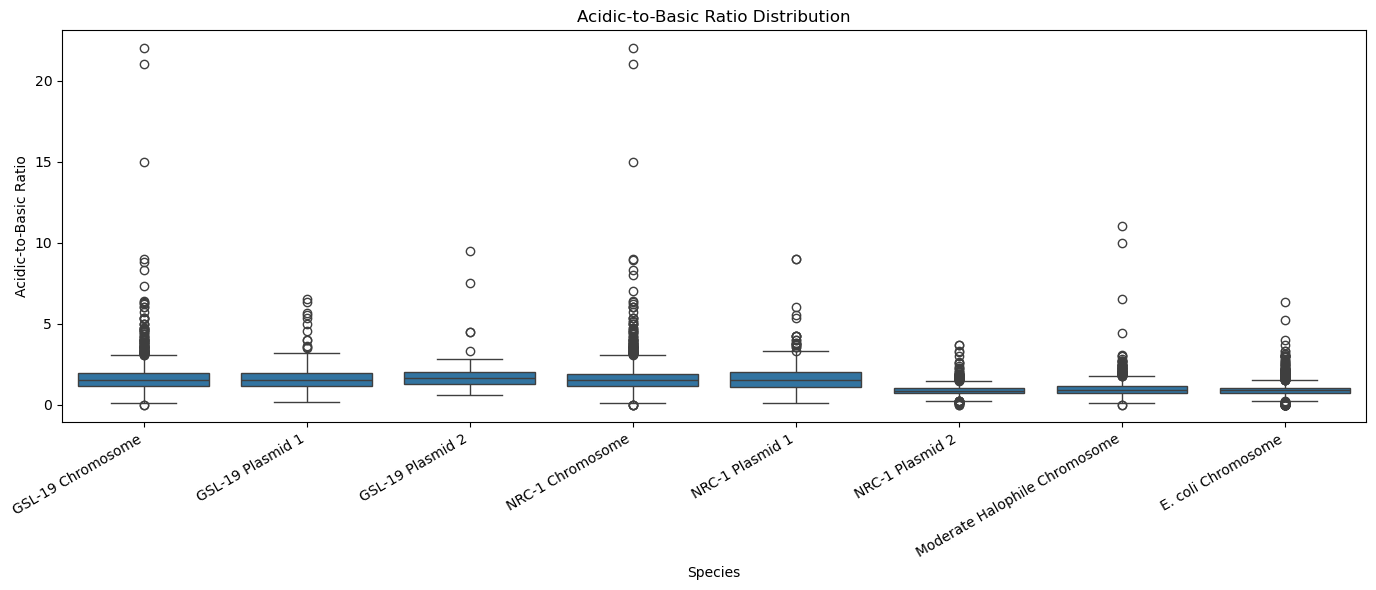

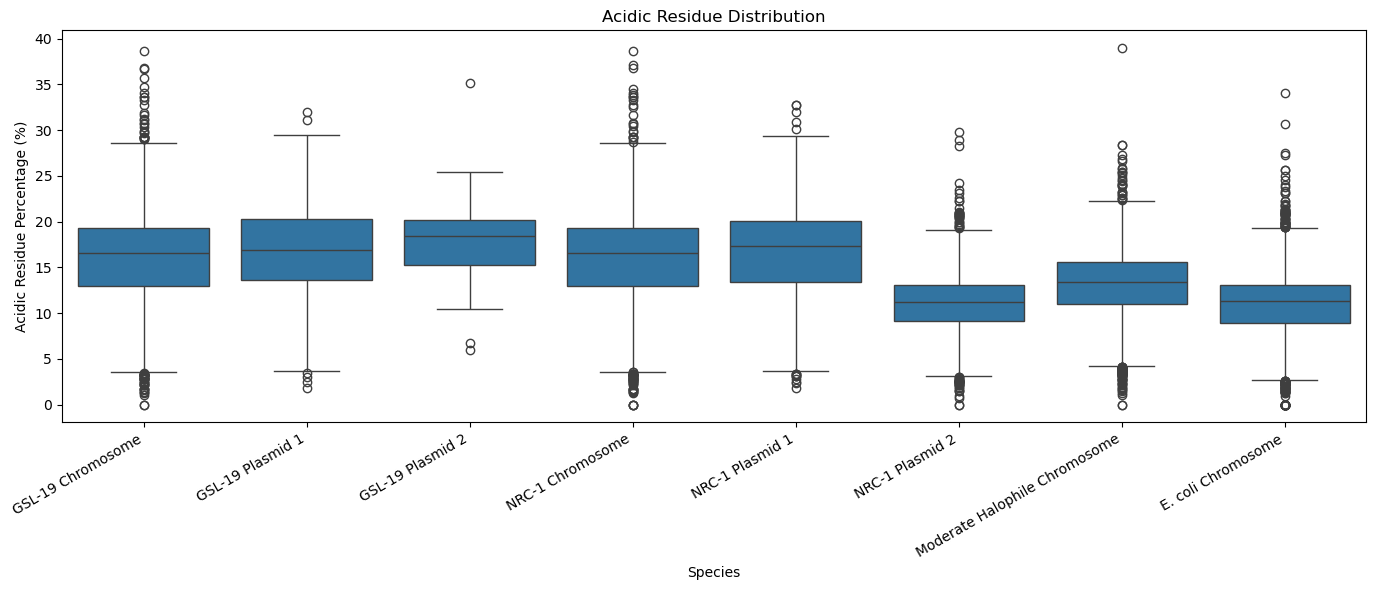

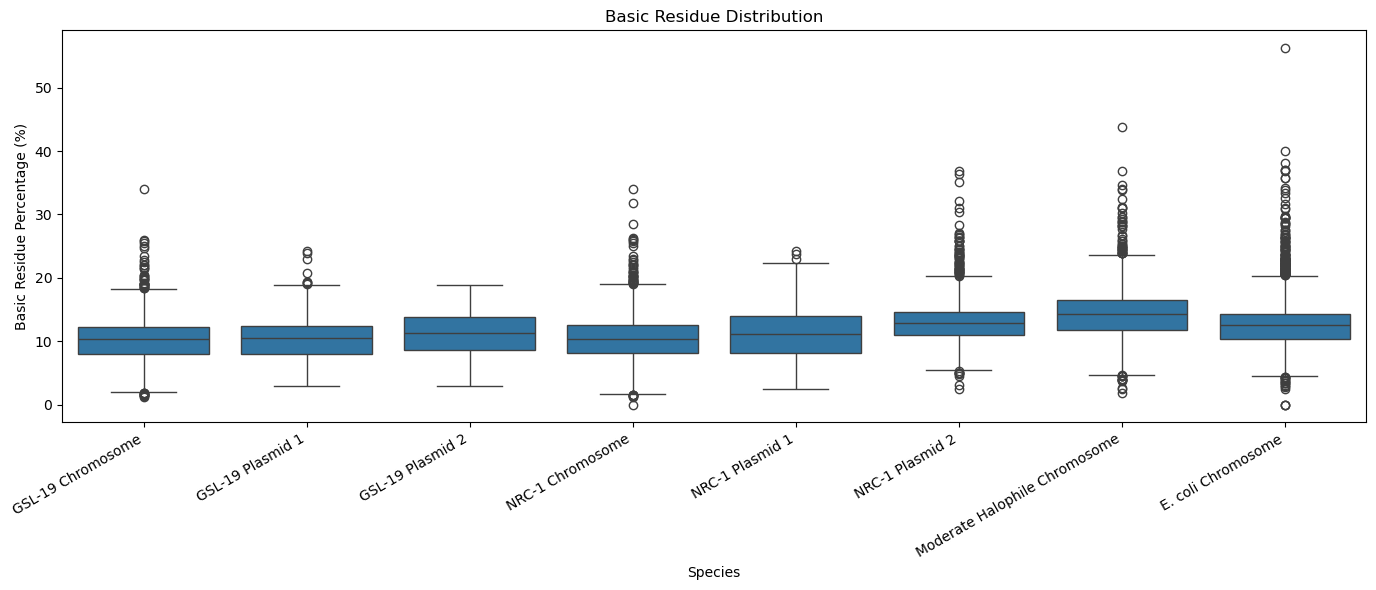

In [167]:
import pandas as pd
from Bio import SeqIO, Entrez
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import seaborn as sns


class ComparativeGenomics:
    def __init__(self):
        # Define reference genomes with accession numbers
        self.reference_genomes = {
            "GSL-19 Chromosome": "CP070377.1",
            "GSL-19 Plasmid 1": "CP070375.1",
            "GSL-19 Plasmid 2": "CP070376.1",
            "NRC-1 Chromosome": "AE004437.1",
            "NRC-1 Plasmid 1": "AE004438.1",
            "NRC-1 Plasmid 2": "AE004439.1",
            "Moderate Halophile Chromosome": "CP002175.1",
            "E. coli Chromosome": "U00096",
            
        }
        # Define amino acid classifications
        self.acidic_aa = ['D', 'E']  # Aspartate and Glutamate are acidic
        self.basic_aa = ['K', 'R', 'H']  # Lysine, Arginine, and Histidine are basic

    def fetch_genome(self, accession):
        """Fetch genome from NCBI using accession number."""
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()
            return record
        except Exception as e:
            print(f"Error fetching genome {accession}: {e}")
            return None

    def analyze_protein_adaptations(self, genome_record):
        """Analyze proteins for acidic and basic residue content."""
        protein_features = []
        for feature in genome_record.features:
            if feature.type == "CDS" and "translation" in feature.qualifiers:
                protein_seq = feature.qualifiers["translation"][0]
                try:
                    protein_analysis = ProteinAnalysis(protein_seq)
                    acidic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.acidic_aa)
                    basic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.basic_aa)

                    protein_info = {
                        'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                        'acidic_percentage': (acidic_content / len(protein_seq)) * 100,
                        'basic_percentage': (basic_content / len(protein_seq)) * 100,
                        'acidic_to_basic_ratio': acidic_content / (basic_content if basic_content > 0 else 1),
                    }
                    protein_features.append(protein_info)
                except Exception as e:
                    print(f"Error analyzing protein {feature.qualifiers.get('locus_tag', ['Unknown'])[0]}: {e}")
        return pd.DataFrame(protein_features)

    def plot_combined_distribution(self, data, value_col, title, ylabel, species_order):
        """Plot distribution of values for chromosomes and plasmids combined."""
        data['Species'] = pd.Categorical(data['Species'], categories=species_order, ordered=True)
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=data, x='Species', y=value_col)
        plt.title(title)
        plt.xlabel('Species')
        plt.ylabel(ylabel)
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()


def main():
    Entrez.email = "your_email@example.com"  # Replace with your email

    # Instantiate the class
    analyzer = ComparativeGenomics()

    protein_features_dfs = []  # Store protein features for each species
    species_order = [
        "GSL-19 Chromosome", "GSL-19 Plasmid 1", "GSL-19 Plasmid 2",
        "NRC-1 Chromosome", "NRC-1 Plasmid 1", "NRC-1 Plasmid 2","Moderate Halophile Chromosome",
        "E. coli Chromosome"
    ]

    # Fetch and analyze genomes
    for name, accession in analyzer.reference_genomes.items():
        print(f"Fetching genome: {name} ({accession})...")
        genome = analyzer.fetch_genome(accession)
        if genome:
            print(f"Analyzing genome: {name}")
            protein_features = analyzer.analyze_protein_adaptations(genome)
            protein_features['Species'] = name
            protein_features_dfs.append(protein_features)

    # Combine all protein features into a single DataFrame
    combined_df = pd.concat(protein_features_dfs)

    # Plot distributions
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_to_basic_ratio', 'Acidic-to-Basic Ratio Distribution', 'Acidic-to-Basic Ratio', species_order
    )
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_percentage', 'Acidic Residue Distribution', 'Acidic Residue Percentage (%)', species_order
    )
    analyzer.plot_combined_distribution(
        combined_df, 'basic_percentage', 'Basic Residue Distribution', 'Basic Residue Percentage (%)', species_order
    )


if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
from Bio import SeqIO, Entrez
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns


class ComparativeGenomics:
    def __init__(self):
        # Define reference genomes and local files
        self.reference_genomes = {
            "GSL-19 Chromosome": "CP070377.1",
            "GSL-19 Plasmid 1": "CP070375.1",
            "GSL-19 Plasmid 2": "CP070376.1",
            "E. coli Chromosome": "U00096",
            "Moderate Halophile Chromosome": "CP002175.1",
            "NRC-1 Chormosome": "AE004437.1",
            "NRC-1 Plasmid 1": "AE004438.1",
            "NRC-1 Plasmid 2": "AF016485"
        }

        # Define amino acid classifications
        self.acidic_aa = ['D', 'E']
        self.basic_aa = ['K', 'R', 'H']

    def read_genome_from_file(self, file_path, file_format="genbank"):
        """Read genome sequence from a local file."""
        print(f"Reading genome from file: {file_path}")
        try:
            return SeqIO.read(file_path, file_format)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return None

    def fetch_genome(self, accession):
        """Fetch genome from NCBI."""
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()
            return record
        except Exception as e:
            print(f"Error fetching {accession}: {str(e)}")
            return None

    def analyze_protein_adaptations(self, genome_record):
        """Analyze proteins for acidic/basic residue content."""
        protein_features = []
        for feature in genome_record.features:
            if feature.type == "CDS" and 'translation' in feature.qualifiers:
                protein_seq = feature.qualifiers['translation'][0]
                try:
                    protein_analysis = ProteinAnalysis(protein_seq)
                    acidic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.acidic_aa)
                    basic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.basic_aa)

                    protein_info = {
                        'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                        'acidic_percentage': (acidic_content / len(protein_seq)) * 100,
                        'basic_percentage': (basic_content / len(protein_seq)) * 100,
                        'acidic_to_basic_ratio': acidic_content / (basic_content if basic_content > 0 else 1)
                    }
                    protein_features.append(protein_info)
                except Exception as e:
                    print(f"Error analyzing protein {feature.qualifiers.get('locus_tag', ['Unknown'])[0]}: {str(e)}")
        return pd.DataFrame(protein_features)

    def plot_combined_distribution(self, data, value_col, title, ylabel, species_order):
        """Generic plot function for combined plasmids and chromosomes."""
        data['Species'] = pd.Categorical(data['Species'], categories=species_order, ordered=True)
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=data, x='Species', y=value_col)
        plt.title(title)
        plt.xlabel('Species')
        plt.ylabel(ylabel)
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()


def main():
    analyzer = ComparativeGenomics()
    Entrez.email = "your_email@example.com"  # Replace with your email

    protein_features_dfs = []  # Store protein features for each species
    labels = []  # Store species labels
    species_order = [
        "GSL-19 Chromosome", "GSL-19 Plasmid 1", "GSL-19 Plasmid 2",
        "NRC-1 Chromosome", "NRC-1 Plasmid 1", "NRC-1 Plasmid 2",
        "Moderate Halophile Chromosome", "E. coli Chromosome"
    ]

    genome_records = {}

    # Fetch and analyze remote genomes
    for name, accession in analyzer.reference_genomes.items():
        print(f"\nFetching genome: {name} ({accession})...")
        genome = analyzer.fetch_genome(accession)
        if genome:
            genome_records[name] = genome

    # Read and analyze local genome files
    for label, file_path in analyzer.local_files.items():
        print(f"\nReading genome from local file: {file_path}")
        genome = analyzer.read_genome_from_file(file_path)
        if genome:
            genome_records[label] = genome

    # Analyze all genomes
    for name, genome in genome_records.items():
        print(f"\nAnalyzing genome: {name}")
        protein_features = analyzer.analyze_protein_adaptations(genome)
        protein_features['Species'] = name
        protein_features_dfs.append(protein_features)

    # Combine protein feature data
    combined_df = pd.concat(protein_features_dfs)

    # Plot acidic-to-basic ratio
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_to_basic_ratio', 'Acidic-to-Basic Ratio Distribution', 'Acidic-to-Basic Ratio', species_order
    )

    # Plot acidic residue distribution
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_percentage', 'Acidic Residue Distribution', 'Acidic Residue Percentage (%)', species_order
    )

    # Plot basic residue distribution
    analyzer.plot_combined_distribution(
        combined_df, 'basic_percentage', 'Basic Residue Distribution', 'Basic Residue Percentage (%)', species_order
    )


if __name__ == "__main__":
    main()


Fetching genome: CP070377.1
Fetching genome: U00096
Fetching genome: CP159204.1
Fetching genome: AE004437.1


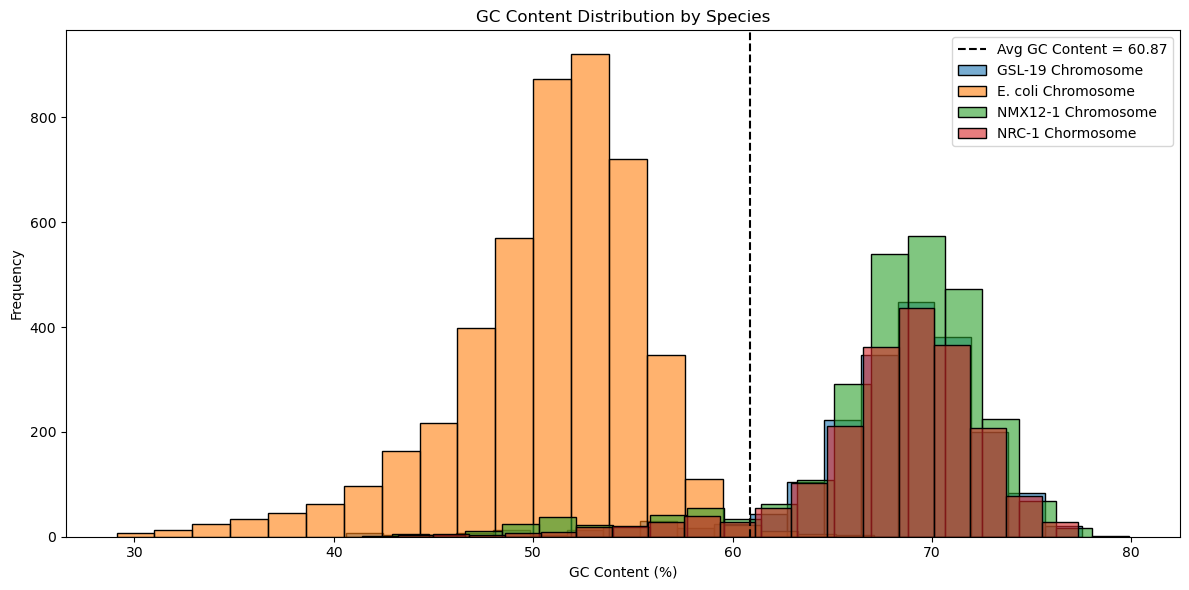

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO


class ComparativeGenomics:
    def __init__(self):
        # Define reference genomes
        self.reference_genomes = {
            "GSL-19 Chromosome": "CP070377.1",
            #"GSL-19 Plasmid 1": "CP070375.1",
            #"GSL-19 Plasmid 2": "CP070376.1",
            "E. coli Chromosome": "U00096",
            #"Moderate Halophile Chromosome": "CP002175.1",
            "NMX12-1 Chromosome": "CP159204.1",
            #"NMX12-1 Plasmid 1": "CP159203",
            #"NMX12-1 Plasmid 2": "CP159205",
            #"NMX12-1 Plasmid 3": "CP159206",
            #"NMX12-1 Plasmid 4": "CP159207",
            #"NMX12-1 Plasmid 5": "CP159208",
            "NRC-1 Chormosome": "AE004437.1",
            #"NRC-1 Plasmid 1": "AE004438.1",
            #"NRC-1 Plasmid 2": "AF016485"
            
        }

    def fetch_genome(self, accession):
        """Fetch genome from NCBI."""
        try:
            print(f"Fetching genome: {accession}")
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            genome = SeqIO.read(handle, "genbank")
            handle.close()
            return genome
        except Exception as e:
            print(f"Error fetching genome {accession}: {e}")
            return None

    def analyze_gc_content(self, genome, window_size=1000):
        """Analyze GC content distribution."""
        gc_data = []
        sequence = str(genome.seq)

        for i in range(0, len(sequence) - window_size, window_size):
            window = sequence[i:i + window_size]
            gc_content = (window.count('G') + window.count('C')) / len(window) * 100
            gc_data.append(gc_content)

        return gc_data

    def plot_gc_content_histogram(self, gc_content_data):
        """Plot a histogram of GC content."""
        plt.figure(figsize=(12, 6))
        for species, gc_content in gc_content_data.items():
            sns.histplot(gc_content, bins=20, kde=False, label=species, alpha=0.6)
        avg_gc = pd.concat([pd.Series(data) for data in gc_content_data.values()]).mean()
        plt.axvline(avg_gc, color='black', linestyle='--', label=f"Avg GC Content = {avg_gc:.2f}")
        plt.xlabel("GC Content (%)")
        plt.ylabel("Frequency")
        plt.title("GC Content Distribution by Species")
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    analyzer = ComparativeGenomics()
    Entrez.email = "your_email@example.com"  # Replace with your email

    gc_content_data = {}

    for species, accession in analyzer.reference_genomes.items():
        genome = analyzer.fetch_genome(accession)
        if genome:
            gc_content = analyzer.analyze_gc_content(genome)
            gc_content_data[species] = gc_content
        else:
            print(f"Failed to fetch genome for {species}")
    

    if gc_content_data:
        analyzer.plot_gc_content_histogram(gc_content_data)


if __name__ == "__main__":
    main()


Fetching genome: CP070375.1
Fetching genome: CP070376.1
Fetching genome: CP159203
Fetching genome: CP159205
Fetching genome: CP159206
Fetching genome: CP159207
Fetching genome: CP159208
Fetching genome: AE004438.1
Fetching genome: AF016485


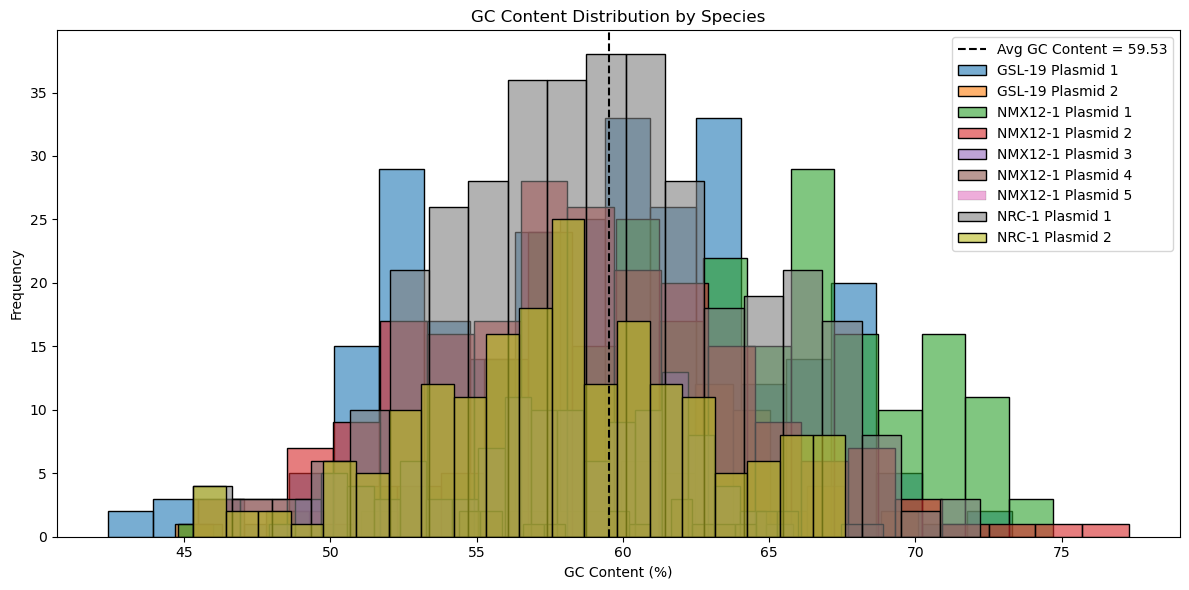

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO


class ComparativeGenomics:
    def __init__(self):
        # Define reference genomes
        self.reference_genomes = {
            #"GSL-19 Chromosome": "CP070377.1",
            "GSL-19 Plasmid 1": "CP070375.1",
            "GSL-19 Plasmid 2": "CP070376.1",
            #"E. coli Chromosome": "U00096",
            #"Moderate Halophile Chromosome": "CP002175.1",
            #"NMX12-1 Chromosome": "CP159204.1",
            "NMX12-1 Plasmid 1": "CP159203",
            "NMX12-1 Plasmid 2": "CP159205",
            "NMX12-1 Plasmid 3": "CP159206",
            "NMX12-1 Plasmid 4": "CP159207",
            "NMX12-1 Plasmid 5": "CP159208",
            #"NRC-1 Chormosome": "AE004437.1",
            "NRC-1 Plasmid 1": "AE004438.1",
            "NRC-1 Plasmid 2": "AF016485"
            
        }

    def fetch_genome(self, accession):
        """Fetch genome from NCBI."""
        try:
            print(f"Fetching genome: {accession}")
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            genome = SeqIO.read(handle, "genbank")
            handle.close()
            return genome
        except Exception as e:
            print(f"Error fetching genome {accession}: {e}")
            return None

    def analyze_gc_content(self, genome, window_size=1000):
        """Analyze GC content distribution."""
        gc_data = []
        sequence = str(genome.seq)

        for i in range(0, len(sequence) - window_size, window_size):
            window = sequence[i:i + window_size]
            gc_content = (window.count('G') + window.count('C')) / len(window) * 100
            gc_data.append(gc_content)

        return gc_data

    def plot_gc_content_histogram(self, gc_content_data):
        """Plot a histogram of GC content."""
        plt.figure(figsize=(12, 6))
        for species, gc_content in gc_content_data.items():
            sns.histplot(gc_content, bins=20, kde=False, label=species, alpha=0.6)
        avg_gc = pd.concat([pd.Series(data) for data in gc_content_data.values()]).mean()
        plt.axvline(avg_gc, color='black', linestyle='--', label=f"Avg GC Content = {avg_gc:.2f}")
        plt.xlabel("GC Content (%)")
        plt.ylabel("Frequency")
        plt.title("GC Content Distribution by Species")
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    analyzer = ComparativeGenomics()
    Entrez.email = "your_email@example.com"  # Replace with your email

    gc_content_data = {}

    for species, accession in analyzer.reference_genomes.items():
        genome = analyzer.fetch_genome(accession)
        if genome:
            gc_content = analyzer.analyze_gc_content(genome)
            gc_content_data[species] = gc_content
        else:
            print(f"Failed to fetch genome for {species}")
    

    if gc_content_data:
        analyzer.plot_gc_content_histogram(gc_content_data)


if __name__ == "__main__":
    main()


Fetching genome: GSL-19 Chromosome (CP070377.1)...
Processing GSL-19 Chromosome...
Fetching genome: GSL-19 Plasmid 1 (CP070375.1)...
Processing GSL-19 Plasmid 1...
Fetching genome: GSL-19 Plasmid 2 (CP070376.1)...
Processing GSL-19 Plasmid 2...
Fetching genome: E. coli Chromosome (U00096)...
Processing E. coli Chromosome...
Fetching genome: NMX12-1 Chromosome (CP159204.1)...
Processing NMX12-1 Chromosome...
Fetching genome: NMX12-1 Plasmid 1 (CP159203)...
Processing NMX12-1 Plasmid 1...
Fetching genome: NMX12-1 Plasmid 2 (CP159205)...
Processing NMX12-1 Plasmid 2...
Fetching genome: NMX12-1 Plasmid 3 (CP159206)...
Processing NMX12-1 Plasmid 3...
Fetching genome: NMX12-1 Plasmid 4 (CP159207)...
Processing NMX12-1 Plasmid 4...
Fetching genome: NMX12-1 Plasmid 5 (CP159208)...
Processing NMX12-1 Plasmid 5...


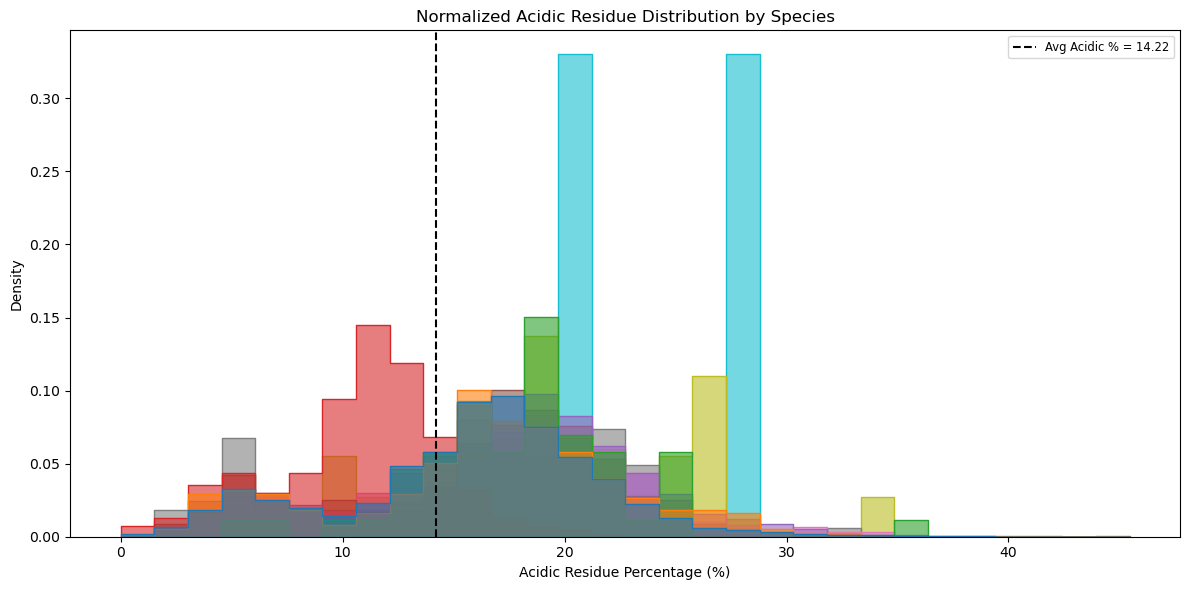

In [153]:
import pandas as pd
from Bio import SeqIO, Entrez
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import seaborn as sns


class ComparativeGenomics:
    def __init__(self):
        self.reference_genomes = {
            "GSL-19 Chromosome": "CP070377.1",
            "GSL-19 Plasmid 1": "CP070375.1",
            "GSL-19 Plasmid 2": "CP070376.1",
            "E. coli Chromosome": "U00096",
            "NMX12-1 Chromosome": "CP159204.1",
            "NMX12-1 Plasmid 1": "CP159203",
            "NMX12-1 Plasmid 2": "CP159205",
            "NMX12-1 Plasmid 3": "CP159206",
            "NMX12-1 Plasmid 4": "CP159207",
            "NMX12-1 Plasmid 5": "CP159208",
        }
        self.acidic_aa = ['D', 'E']  # Aspartate (D) and Glutamate (E) are acidic.

    def fetch_genome(self, accession):
        """Fetch genome sequence from NCBI using accession number."""
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()
            return record
        except Exception as e:
            print(f"Error fetching genome {accession}: {e}")
            return None

    def analyze_acidic_residues(self, genome_record):
        """Analyze acidic residue percentages in protein-coding sequences."""
        acidic_percentages = []

        for feature in genome_record.features:
            if feature.type == "CDS" and "translation" in feature.qualifiers:
                protein_seq = feature.qualifiers["translation"][0]
                acidic_count = sum(protein_seq.count(aa) for aa in self.acidic_aa)
                acidic_percentage = (acidic_count / len(protein_seq)) * 100
                acidic_percentages.append(acidic_percentage)

        return acidic_percentages

    def process_genomes(self):
        """Fetch and process genomes to calculate acidic residue distributions."""
        acidic_data = {}

        for species, accession in self.reference_genomes.items():
            print(f"Fetching genome: {species} ({accession})...")
            genome = self.fetch_genome(accession)

            if genome:
                print(f"Processing {species}...")
                acidic_percentages = self.analyze_acidic_residues(genome)
                acidic_data[species] = acidic_percentages
            else:
                print(f"Failed to fetch or process genome: {species}.")

        return acidic_data

    def plot_acidic_residue_distribution(self, acidic_data):
        """Plot normalized acidic residue distributions for all species."""
        plt.figure(figsize=(12, 6))

        # Flatten data into a DataFrame for seaborn
        plot_data = []
        for species, percentages in acidic_data.items():
            for percentage in percentages:
                plot_data.append({'Species': species, 'Acidic Percentage': percentage})
        df = pd.DataFrame(plot_data)

        # Plot using seaborn histogram
        sns.histplot(
            data=df, x="Acidic Percentage", hue="Species", bins=30,
            element="step", stat="density", common_norm=False, alpha=0.6
        )

        # Add average acidic percentage line
        all_acidic_values = [value for values in acidic_data.values() for value in values]
        avg_acidic_percentage = sum(all_acidic_values) / len(all_acidic_values)
        plt.axvline(avg_acidic_percentage, color='black', linestyle='--', label=f"Avg Acidic % = {avg_acidic_percentage:.2f}")

        # Label the plot
        plt.title("Normalized Acidic Residue Distribution by Species")
        plt.xlabel("Acidic Residue Percentage (%)")
        plt.ylabel("Density")
        plt.legend(loc='upper right', fontsize='small')
        plt.tight_layout()
        plt.show()


def main():
    # Set up email for Entrez
    Entrez.email = "your_email@example.com"  # Replace with your email

    # Instantiate the analyzer and process genomes
    analyzer = ComparativeGenomics()
    acidic_data = analyzer.process_genomes()

    # Plot acidic residue distribution
    analyzer.plot_acidic_residue_distribution(acidic_data)


if __name__ == "__main__":
    main()


Fetching genome: GSL-19 Chromosome (CP070377.1)...
Analyzing genome: GSL-19 Chromosome
Fetching genome: NRC-1 Chromosome (AE004437.1)...
Analyzing genome: NRC-1 Chromosome
Fetching genome: NMX12-1 Chromosome (CP159204.1)...
Analyzing genome: NMX12-1 Chromosome
Fetching genome: Moderate Halophile Chromosome (CP002175.1)...
Analyzing genome: Moderate Halophile Chromosome
Fetching genome: E. coli Chromosome (U00096)...
Analyzing genome: E. coli Chromosome


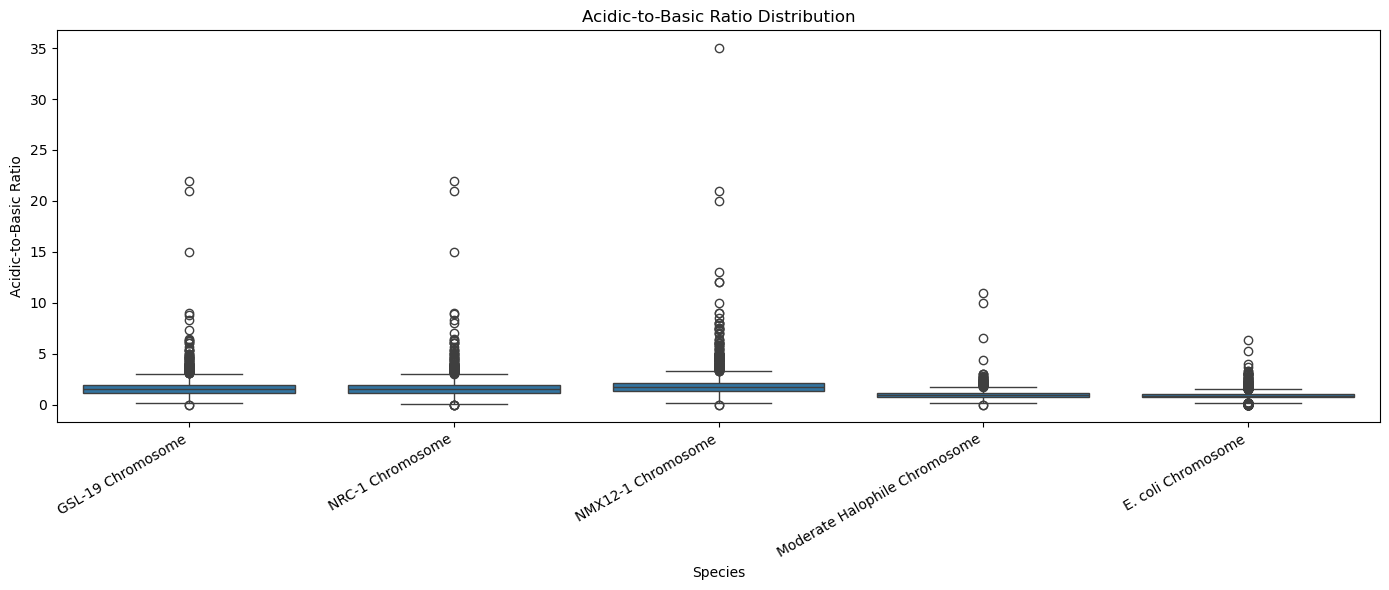

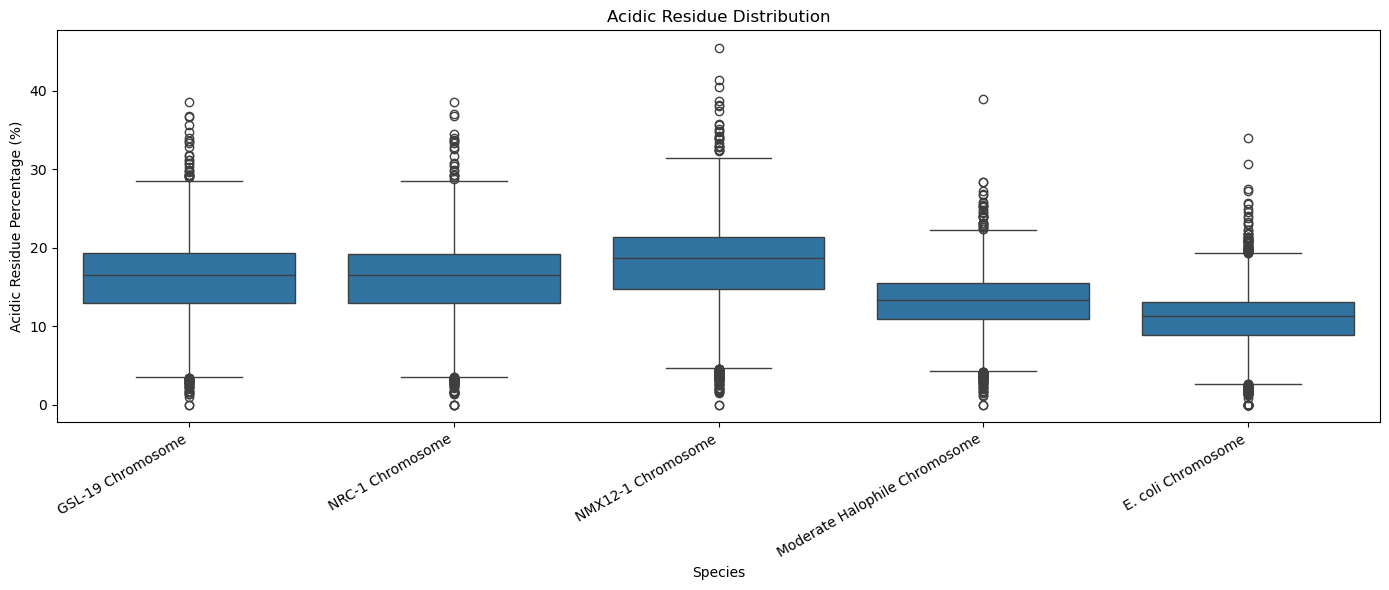

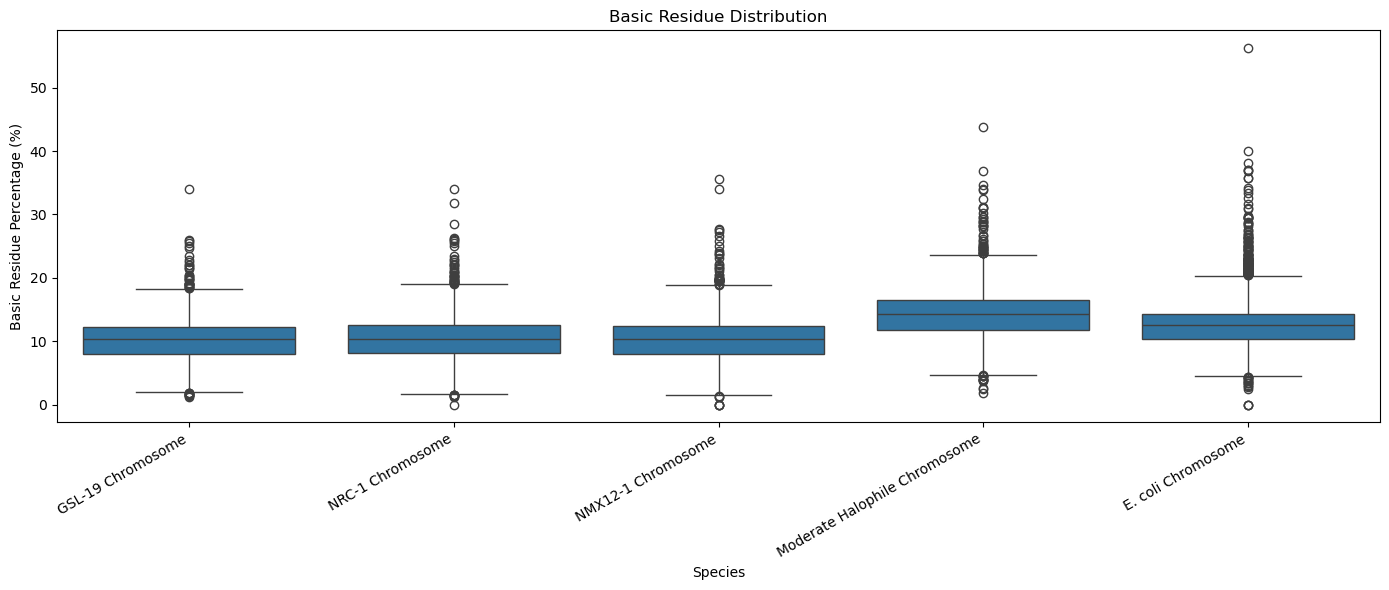

In [169]:
import pandas as pd
from Bio import SeqIO, Entrez
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import seaborn as sns


class ComparativeGenomics:
    def __init__(self):
        # Define reference genomes with accession numbers
        self.reference_genomes = {
            "GSL-19 Chromosome": "CP070377.1",
            #"GSL-19 Plasmid 1": "CP070375.1",
            #"GSL-19 Plasmid 2": "CP070376.1",
            "NRC-1 Chromosome": "AE004437.1",
            #"NRC-1 Plasmid 1": "AE004438.1",
            #"NRC-1 Plasmid 2": "AE004439.1",
            "NMX12-1 Chromosome": "CP159204.1",
            "Moderate Halophile Chromosome": "CP002175.1",
            "E. coli Chromosome": "U00096",
            
        }
        # Define amino acid classifications
        self.acidic_aa = ['D', 'E']  # Aspartate and Glutamate are acidic
        self.basic_aa = ['K', 'R', 'H']  # Lysine, Arginine, and Histidine are basic

    def fetch_genome(self, accession):
        """Fetch genome from NCBI using accession number."""
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()
            return record
        except Exception as e:
            print(f"Error fetching genome {accession}: {e}")
            return None

    def analyze_protein_adaptations(self, genome_record):
        """Analyze proteins for acidic and basic residue content."""
        protein_features = []
        for feature in genome_record.features:
            if feature.type == "CDS" and "translation" in feature.qualifiers:
                protein_seq = feature.qualifiers["translation"][0]
                try:
                    protein_analysis = ProteinAnalysis(protein_seq)
                    acidic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.acidic_aa)
                    basic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.basic_aa)

                    protein_info = {
                        'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                        'acidic_percentage': (acidic_content / len(protein_seq)) * 100,
                        'basic_percentage': (basic_content / len(protein_seq)) * 100,
                        'acidic_to_basic_ratio': acidic_content / (basic_content if basic_content > 0 else 1),
                    }
                    protein_features.append(protein_info)
                except Exception as e:
                    print(f"Error analyzing protein {feature.qualifiers.get('locus_tag', ['Unknown'])[0]}: {e}")
        return pd.DataFrame(protein_features)

    def plot_combined_distribution(self, data, value_col, title, ylabel, species_order):
        """Plot distribution of values for chromosomes and plasmids combined."""
        data['Species'] = pd.Categorical(data['Species'], categories=species_order, ordered=True)
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=data, x='Species', y=value_col)
        plt.title(title)
        plt.xlabel('Species')
        plt.ylabel(ylabel)
        plt.xticks(rotation=30, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()


def main():
    Entrez.email = "your_email@example.com"  # Replace with your email

    # Instantiate the class
    analyzer = ComparativeGenomics()

    protein_features_dfs = []  # Store protein features for each species
    species_order = [
        "GSL-19 Chromosome",
        "NRC-1 Chromosome","NMX12-1 Chromosome","Moderate Halophile Chromosome",
        "E. coli Chromosome"
    ]

    # Fetch and analyze genomes
    for name, accession in analyzer.reference_genomes.items():
        print(f"Fetching genome: {name} ({accession})...")
        genome = analyzer.fetch_genome(accession)
        if genome:
            print(f"Analyzing genome: {name}")
            protein_features = analyzer.analyze_protein_adaptations(genome)
            protein_features['Species'] = name
            protein_features_dfs.append(protein_features)

    # Combine all protein features into a single DataFrame
    combined_df = pd.concat(protein_features_dfs)

    # Plot distributions
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_to_basic_ratio', 'Acidic-to-Basic Ratio Distribution', 'Acidic-to-Basic Ratio', species_order
    )
    analyzer.plot_combined_distribution(
        combined_df, 'acidic_percentage', 'Acidic Residue Distribution', 'Acidic Residue Percentage (%)', species_order
    )
    analyzer.plot_combined_distribution(
        combined_df, 'basic_percentage', 'Basic Residue Distribution', 'Basic Residue Percentage (%)', species_order
    )


if __name__ == "__main__":
    main()
